In [1]:
from pyHalo.PresetModels.external import DMFromGalacticus
from pyHalo.Halos.HaloModels.TNFWFromParams import TNFWFromParams
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import Axes
from pyHalo.Halos.galacticus_util.galacticus_util import GalacticusUtil
from pyHalo.Halos.galacticus_util.galacticus_filter import *
from numpy import random
from scipy.optimize import minimize
from pyHalo.preset_models import CDM
import lenstronomy
import matplotlib
from pyHalo.plotting_routines import plot_multiplane_convergence

## Basic Usage

Create a single realization from galacticus output

In [2]:
np.random.seed(59)

path_hdf5 = "data/TNFW_example.hdf5"

gutil = GalacticusUtil()
nodedata = gutil.read_nodedata_galacticus(path_hdf5)

tree_index = 8
log_mrange = (8,10)
# The coordinates of the normal vector of the plane we project onto when rendering
# In this case coordinates would be projected onto y,z plane
z_source = 2
cone_opening_angle_arcsec = 10
kwargs_los = dict(log_mlow=log_mrange[0],log_mhigh=log_mrange[1]) 

#Choose a random tree
tree_index = np.random.choice(np.unique(nodedata[gutil.PARAM_TREE_INDEX])) 

#Choose a random projection
theta, phi = np.random.random(2) * np.asarray((np.pi,2 * np.pi))


realization_galacticus = DMFromGalacticus(z_source=z_source,galacticus_hdf5=path_hdf5,tree_index=tree_index,
                                            log_mlow_galacticus=log_mrange[0],log_mhigh_galacticus=log_mrange[1],
                                            proj_angle_theta=theta, proj_angle_phi=phi,
                                            cone_opening_angle_arcsec=cone_opening_angle_arcsec,mass_range_is_bound=True,**kwargs_los)

realization contains 144 halos.


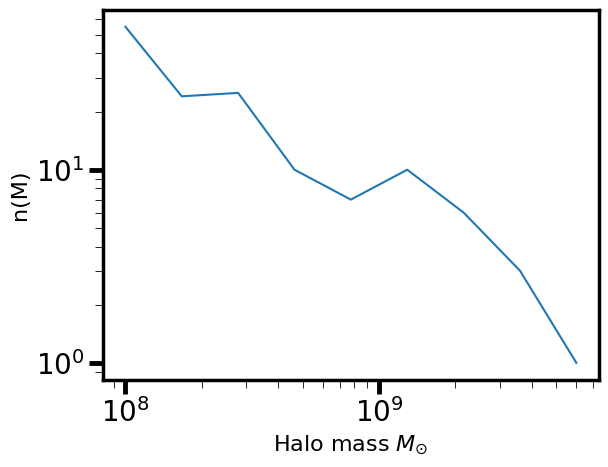

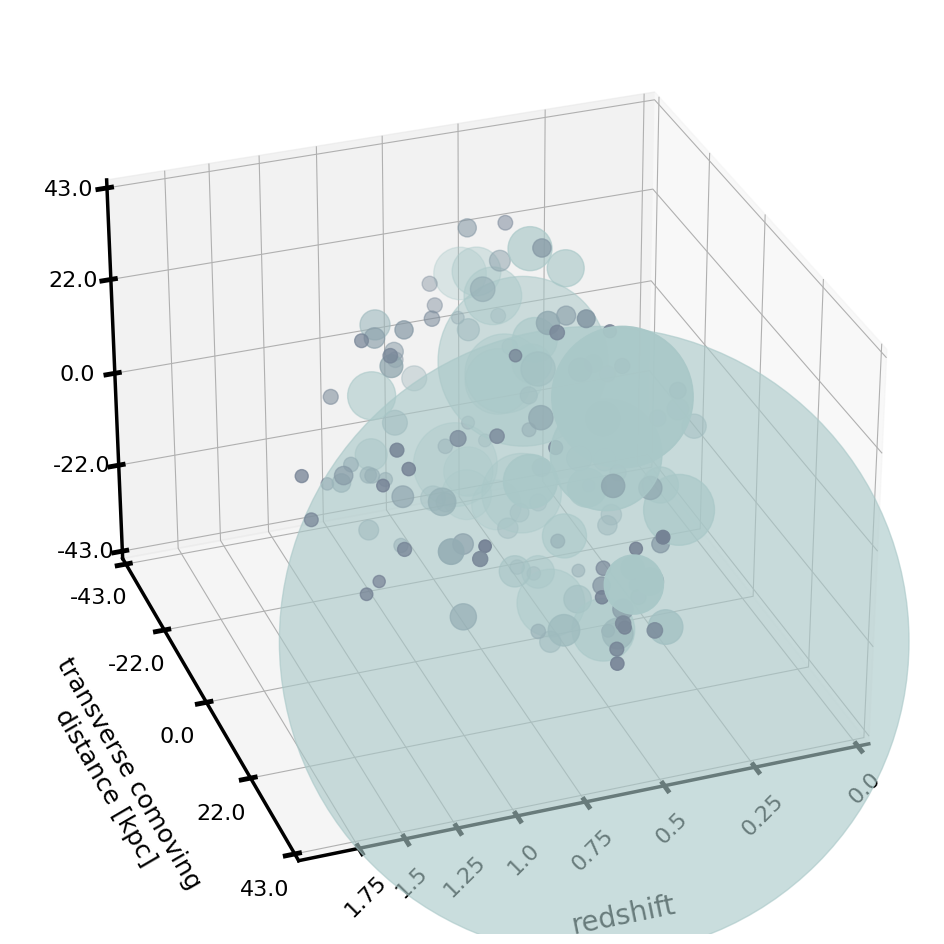

In [3]:
print('realization contains '+str(len(realization_galacticus.halos))+' halos.')
cdm_halo_masses_infall = [halo.mass for halo in realization_galacticus.halos]
N, m = np.histogram(cdm_halo_masses_infall, bins=np.logspace(8, 10, 10))

fig = plt.figure(1)
ax = plt.subplot(111)
ax.loglog(m[0:-1], N)
ax.set_xlabel('Halo mass '+r'$M_{\odot}$', fontsize=16)
ax.set_ylabel('n(M)', fontsize=16)

fig = plt.figure(2)
fig.set_size_inches(14,12)
ax = plt.subplot(111, projection='3d')
realization_galacticus.plot(ax)

## Galacticus Subalo Properties
Feild halos are switched off

realization contains 23 halos.


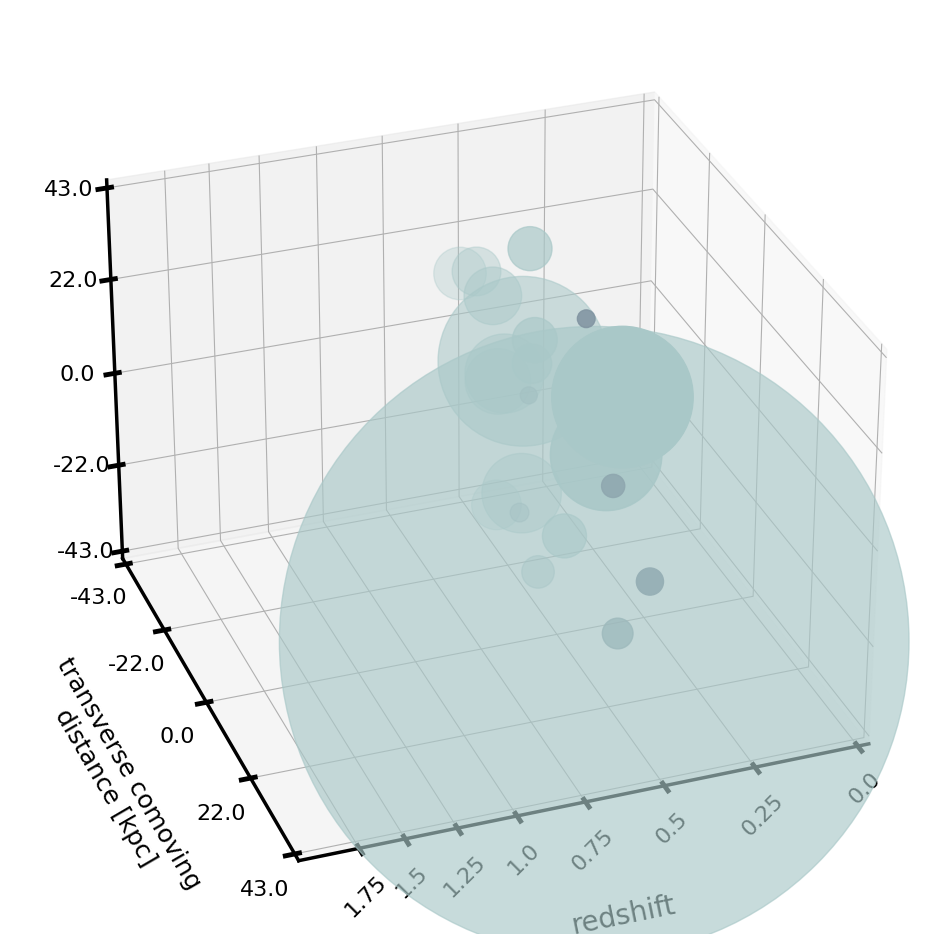

In [4]:
# LOS_normalization = 0.0 switches off feild halos 
realization_galacticus_subhalos = DMFromGalacticus(z_source=z_source,galacticus_hdf5=path_hdf5,tree_index=tree_index,
                                            log_mlow_galacticus=log_mrange[0],log_mhigh_galacticus=log_mrange[1],
                                            proj_angle_theta=theta, proj_angle_phi=phi,
                                            cone_opening_angle_arcsec=cone_opening_angle_arcsec,mass_range_is_bound=True,
                                            LOS_normalization=0.0,**kwargs_los)

subhalos = realization_galacticus_subhalos.halos

print('realization contains '+str(len(realization_galacticus_subhalos.halos))+' halos.')
cdm_halo_masses_infall = [halo.mass for halo in realization_galacticus_subhalos.halos]
N, m = np.histogram(cdm_halo_masses_infall, bins=np.logspace(6, 10, 10))

fig = plt.figure(2)
fig.set_size_inches(14,12)
ax = plt.subplot(111, projection='3d')
realization_galacticus_subhalos.plot(ax)

## Subhalo Properties

Properties of all subhalos, all realizations

Note: the turnover in the infall mass function is an effect of resolution, in the galacticus model. Using our parameters any subhalos that follow below a given bound mass threshold are destroyed, creating an effect where subhalos that are less massive at infall are more likely to be destroyed. 

realization contains 13936 halos.


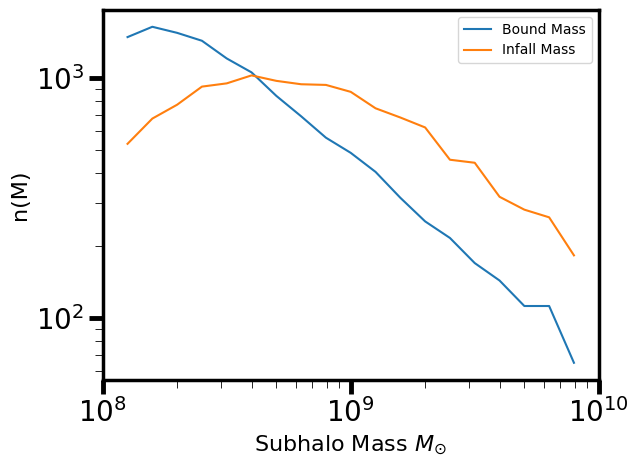

In [5]:
n_projections = 100

# By default subhalos are filtered such that only subhalos from a particular tree
# and those that are within the rendering volume of the cone are included
# we can override, to include all subhalos in the galacticus file in the realization
# we exclude subhalos outside of the virial radius of their host
# since galacticus is not calibrated for these subhalos, we also include host halos

realization_galacticus_subhalos_all = DMFromGalacticus(z_source=z_source,galacticus_hdf5=path_hdf5,tree_index=tree_index,
                                            log_mlow_galacticus=8,log_mhigh_galacticus=13,
                                            proj_angle_theta=theta, proj_angle_phi=phi,
                                            cone_opening_angle_arcsec=cone_opening_angle_arcsec,mass_range_is_bound=True,
                                            nodedata_filter=lambda nd,util: nodedata_filter_subhalos(nd,util) & nodedata_filter_virialized(nd,util),
                                            LOS_normalization=0.0,**kwargs_los)

subhalos_all = realization_galacticus_subhalos_all.halos

print('realization contains '+str(len(subhalos_all))+' halos.')
cdm_halo_masses_bound = [halo.bound_mass for halo in subhalos_all]
cdm_halo_masses_infall = [halo.mass for halo in subhalos_all]
n_bound, m_bound = np.histogram(cdm_halo_masses_bound, bins=np.logspace(8.1, 10, 20))
n_infall, m_infall = np.histogram(cdm_halo_masses_infall, bins=np.logspace(8.1, 10, 20))

fig = plt.figure(1)
ax = plt.subplot(111)
ax.plot(m_bound[0:-1], n_bound, label="Bound Mass")
ax.plot(m_infall[0:-1], n_infall, label="Infall Mass")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel('Subhalo Mass '+r'$M_{\odot}$', fontsize=16)
ax.set_ylabel('n(M)', fontsize=16)

ax.set_xlim(1E8,1E10)
ax.legend()

Subhalo Density Fits

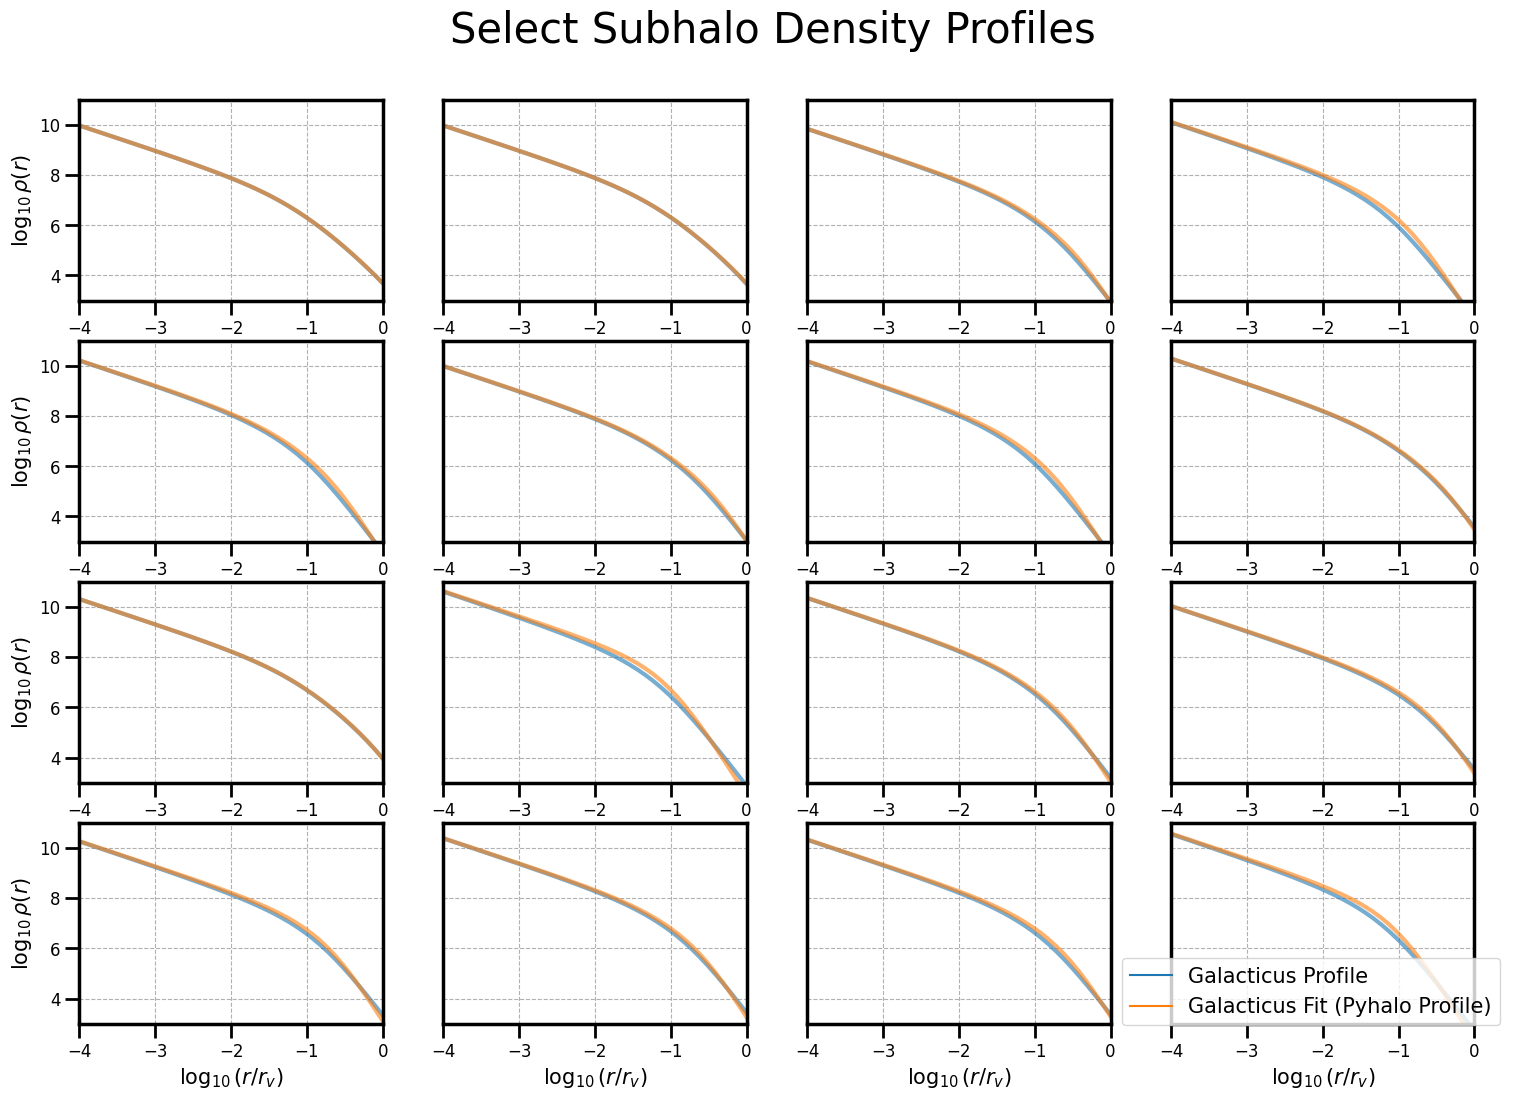

In [6]:
nplotsx, nplotsy = 4,4
xscale = (-4,0)
yscale = (3,11)
fig, axs = plt.subplots(nplotsy,nplotsx,figsize=(18,12))

def plot_galacticus_profile(ax,nodedata,id,gutil,**kwargs):
    nd_sub = nodedata_apply_filter(nodedata,nodedata[gutil.PARAM_NODE_ID] == id)

    density_profile_radius = nd_sub[gutil.PARAM_DENSITY_PROFILE_RADIUS][0]
    density_profile = nd_sub[gutil.PARAM_DENSITY_PROFILE][0] / 1E9
    rv = nd_sub[gutil.PARAM_RADIUS_VIRIAL][0] 

    return ax.plot(np.log10(density_profile_radius / rv),np.log10(density_profile),label="Galacticus Density Profile",**kwargs)

def plot_pyhalo_density_profile(ax,subhalo, nodedata, gutil,**kwargs):
    id = subhalo.id
    
    nd_sub = nodedata_apply_filter(nodedata,nodedata[gutil.PARAM_NODE_ID] == id)

    density_profile_radius = nd_sub[gutil.PARAM_DENSITY_PROFILE_RADIUS][0] * 1E3
    rv = subhalo.params_physical[TNFWFromParams.KEY_RV]
    density_profile = subhalo.density_profile_3d(density_profile_radius)

    return ax.plot(np.log10(density_profile_radius / rv),np.log10(density_profile),label="PyHalo Density Profile",**kwargs)

for y,ax_row in enumerate(axs):
    for x,ax in enumerate(ax_row):
        ax:plt.Axes = ax

        ax.set_xlim(*xscale,)
        ax.set_ylim(*yscale)
        ax.set_xlabel(r"$\log_{10}(r/r_v)$",fontdict=dict(fontsize=15))
        ax.set_ylabel(r"$\log_{10}\rho(r)$",fontdict=dict(fontsize=15))
        ax.grid(linestyle="--")

        ax.tick_params(axis="both", labelsize=12,width=2)

        if x > 0:
            ax.tick_params(left=False,labelleft=False)
            ax.set_ylabel("")
        if y < nplotsy - 1:
            ax.set_xlabel("")

        n = nplotsx * y + x

        sh = subhalos[n]

        plot_galacticus_profile(ax,nodedata,sh.id,gutil,linewidth=3,alpha=0.6)
        plot_pyhalo_density_profile(ax,sh,nodedata,gutil,linewidth=3,alpha=0.6)

ax_main = fig.add_axes((0.1,0.1,0.82,0.82),facecolor=(1,1,1,0))
ax_main.axis("off")

ax_main.set_title("Select Subhalo Density Profiles",fontdict=dict(fontsize=30))
ax_main.set_xlim((0,1))
ax_main.set_ylim((0,1))

ax_main.plot((-10),(-10),label="Galacticus Profile")
ax_main.plot((-10),(-10),label="Galacticus Fit (Pyhalo Profile)")


ax_main.legend(loc="lower right",fontsize=15)

Text(0, 0.5, 'Probability Density')

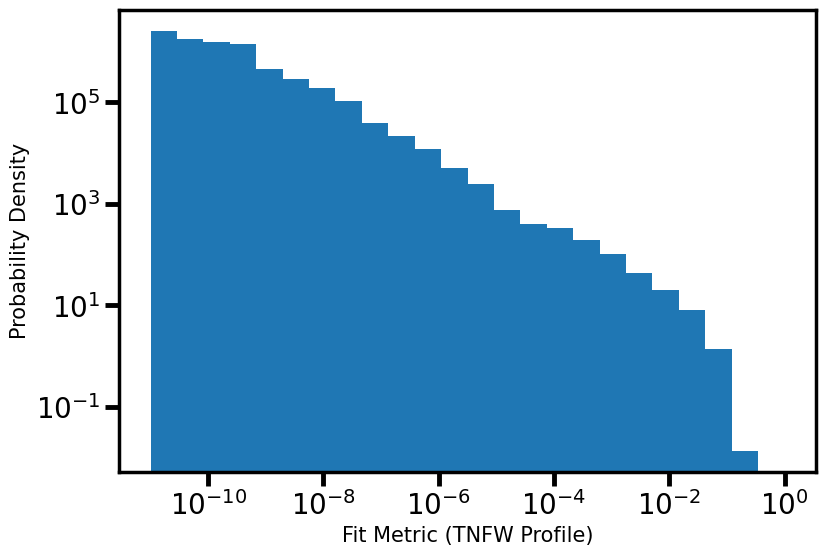

In [7]:
fig, ax = plt.subplots(figsize=(9,6))
ax.hist(nodedata['metricTidalTruncationNFW'], bins=np.logspace(-11,0,25), density=True)
ax.loglog()
ax.set_xlabel("Fit Metric (TNFW Profile)",fontsize=15)
ax.set_ylabel("Probability Density",fontsize=15)

Comparing Parameters - Galacticus and pyhalo

In [8]:
log_mrange = (9.48,11)

nrealizations_galacticus = 80
cone_opening_angle_arcsec_large = 50
nrealizations_pyhalo = 80

galacticus_subhalos = []
pyh_subhalos = []

z_lens = 0.5

for i in range(nrealizations_galacticus):
    tree_index = np.random.choice(np.unique(nodedata[gutil.PARAM_TREE_INDEX])) 
    theta, phi = np.random.random(2) * np.asarray((np.pi,2 * np.pi))
    
    galacticus_subhalos += DMFromGalacticus(z_source=z_source,galacticus_hdf5=path_hdf5,tree_index=tree_index,
                                                        log_mlow_galacticus=log_mrange[0],log_mhigh_galacticus=log_mrange[1],
                                                        proj_angle_theta=theta, proj_angle_phi=phi,
                                                        cone_opening_angle_arcsec=cone_opening_angle_arcsec_large,mass_range_is_bound=False,
                                                        LOS_normalization=0.0,**kwargs_los).halos

for i in range(nrealizations_pyhalo):
    pyh_subhalos += CDM(z_lens, z_source, cone_opening_angle_arcsec=cone_opening_angle_arcsec_large,LOS_normalization=0,log_mlow=log_mrange[0],log_mhigh=log_mrange[1],log_m_host=13).halos

In [9]:
pyh_filter = lambda sh: sh.bound_mass > 1E8

galacticus_rho = np.asarray([sh.params_physical[TNFWFromParams.KEY_RHO_S] for sh in galacticus_subhalos])
galacticus_rs = np.asarray([sh.params_physical[TNFWFromParams.KEY_RS] for sh in galacticus_subhalos])

pyh_rho = np.asarray([sh.params_physical[TNFWFromParams.KEY_RHO_S] for sh in pyh_subhalos if pyh_filter(sh)])
pyh_rs = np.asarray([sh.params_physical[TNFWFromParams.KEY_RS] for sh in pyh_subhalos if pyh_filter(sh)])

galacticus_mass = np.asarray([sh.mass for sh in galacticus_subhalos])
galacticus_c = np.asarray([sh.c for sh in galacticus_subhalos])

pyh_mass = np.asarray([sh.mass for sh in pyh_subhalos if pyh_filter(sh)])
pyh_c = np.asarray([sh.c for sh in pyh_subhalos if pyh_filter(sh)])

galacticus_rt = np.asarray([sh.params_physical[TNFWFromParams.KEY_RT] for sh in galacticus_subhalos])
galacticus_mass_bound = np.asarray([sh.bound_mass for sh in galacticus_subhalos])

pyh_rt = np.asarray([sh.params_physical[TNFWFromParams.KEY_RT] for sh in pyh_subhalos if pyh_filter(sh)])

In [10]:
print("Number of pyHalo subhalos:",len(pyh_subhalos))
print("Number of galacticus subhalos:",len(galacticus_subhalos))


Number of pyHalo subhalos: 7598
Number of galacticus subhalos: 5938


[]

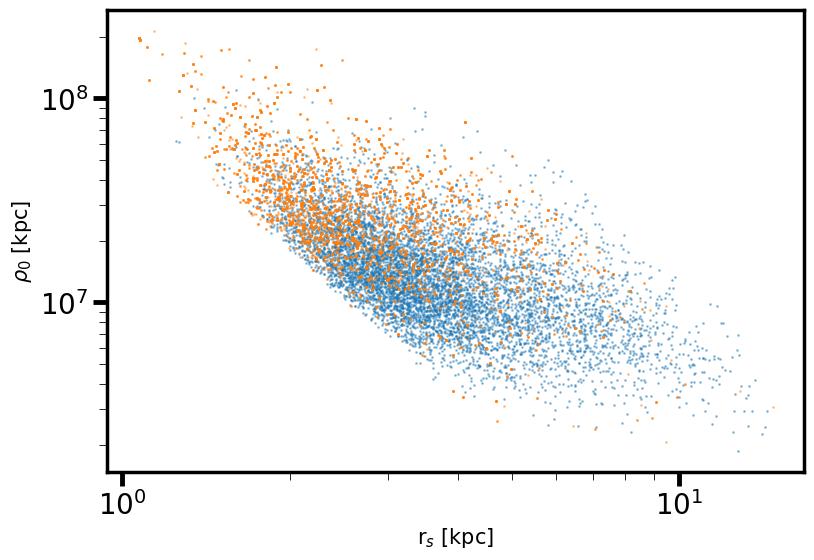

In [11]:
fig, ax = plt.subplots(figsize=(9,6))

marker_size = 1

ax.scatter(pyh_rs,pyh_rho,alpha=0.4,s=marker_size)
ax.scatter(galacticus_rs,galacticus_rho,alpha=0.4,s=marker_size)

ax.set_xlabel(r"r$_s$ [kpc]",fontsize=15)
ax.set_ylabel(r"$\rho_0$ [kpc]",fontsize=15)

ax.loglog()

[]

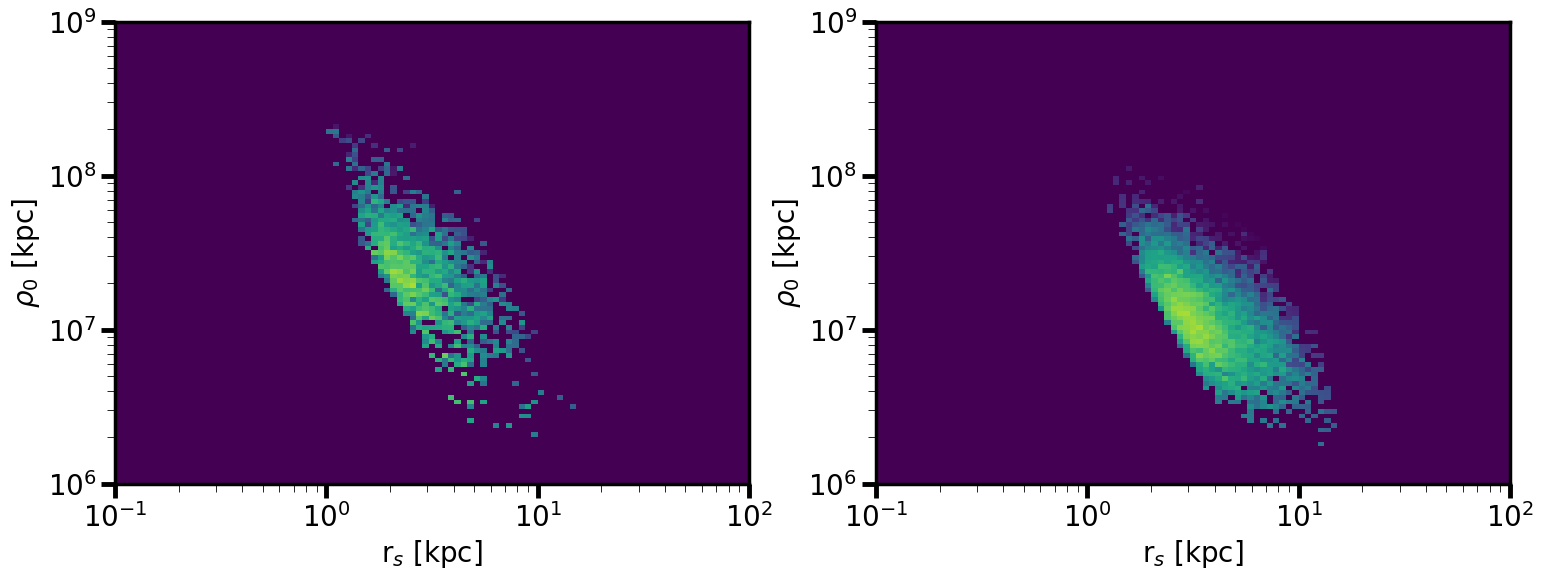

In [12]:
fig,axs = plt.subplots(ncols=2,figsize=(18,6))
ax1 = axs[0]
ax2 = axs[1]

bins_rho = np.logspace(6,9,100)
bins_rs = np.logspace(-1,2,100)

*_,h1 = ax1.hist2d(galacticus_rs,galacticus_rho,bins=(bins_rs,bins_rho),norm=matplotlib.colors.LogNorm(vmin=1E-10,vmax=1E-7,clip=True),density=True)
*_,h2 = ax2.hist2d(pyh_rs,pyh_rho,bins=(bins_rs,bins_rho),norm=matplotlib.colors.LogNorm(vmin=1E-10,vmax = 1E-7,clip=True),density=True)

for ax in axs:
    ax.set_xlabel(r"r$_s$ [kpc]",fontsize=20)
    ax.set_ylabel(r"$\rho_0$ [kpc]",fontsize=20)


ax1.loglog()
ax2.loglog()

[]

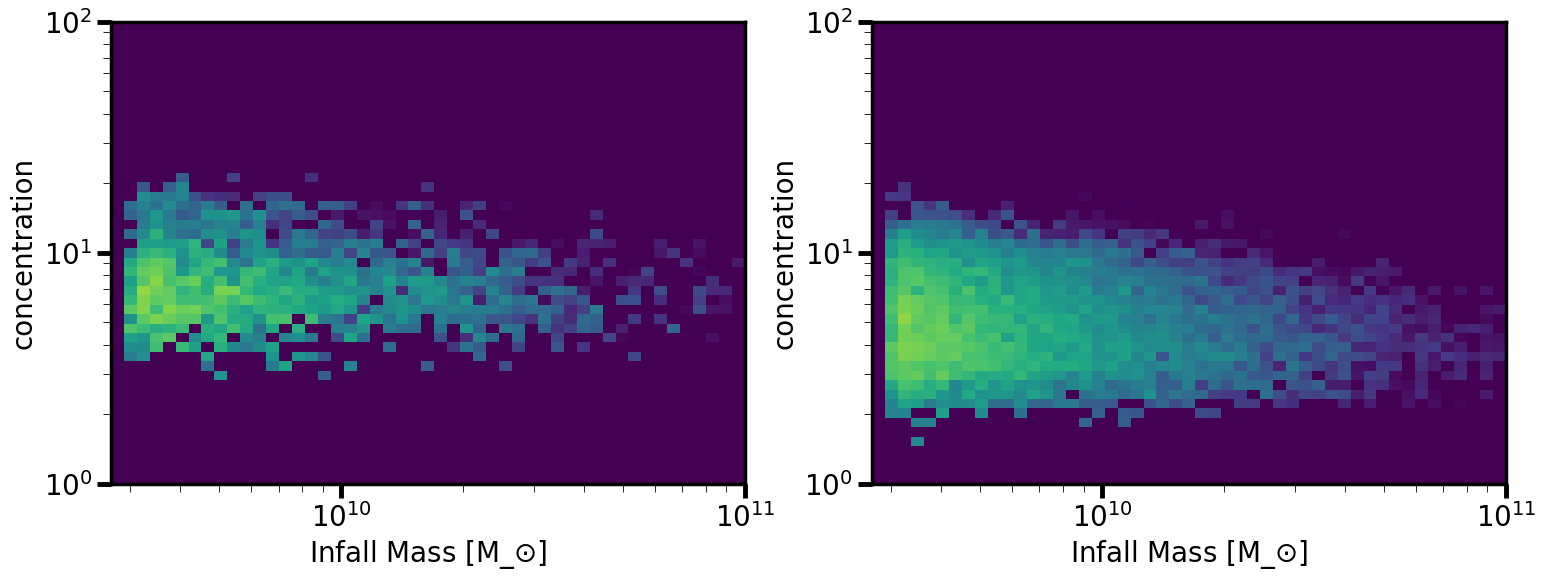

In [13]:
fig,axs = plt.subplots(ncols=2,figsize=(18,6))

bins_m = np.logspace(9.43,11,50)
bins_c = np.logspace(0,2)

*_, h1 = axs[0].hist2d(galacticus_mass,galacticus_c,bins=(bins_m,bins_c),norm=matplotlib.colors.LogNorm(vmin=1E-13,vmax=2E-10,clip=True),density=True)
*_, h2 = axs[1].hist2d(pyh_mass,pyh_c,bins=(bins_m,bins_c),norm=matplotlib.colors.LogNorm(vmin=1E-13,vmax=2E-10, clip=True),density=True)

for ax in axs:
    ax.set_xlabel(r"Infall Mass [M_$\odot$]",fontsize=20)
    ax.set_ylabel(r"concentration",fontsize=20)



axs[0].loglog()
axs[1].loglog()

## Multiplane Lensing

<Axes: >

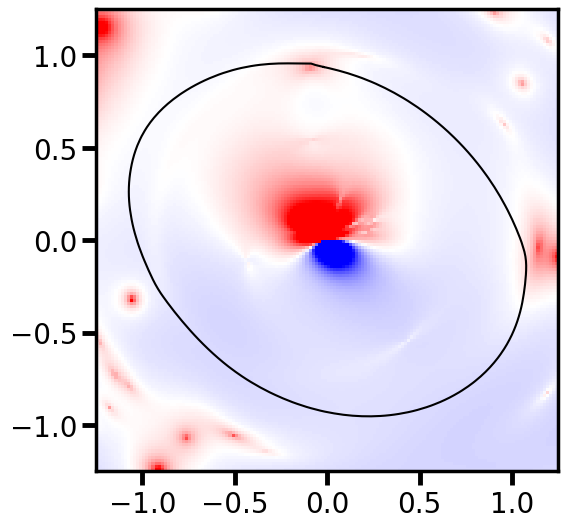

In [14]:
plot_multiplane_convergence(realization_galacticus,cone_opening_angle_arcsec=2.5,subtract_mean_kappa=True,npix=150)